<a href="https://colab.research.google.com/github/quinn-dougherty/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/DS_Unit_1_Sprint_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 1 Sprint Challenge 4

## Exploring Data, Testing Hypotheses

In this sprint challenge you will look at a dataset of people being approved or rejected for credit.

https://archive.ics.uci.edu/ml/datasets/Credit+Approval

Data Set Information: This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.

Attribute Information:
- A1: b, a.
- A2: continuous.
- A3: continuous.
- A4: u, y, l, t.
- A5: g, p, gg.
- A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
- A7: v, h, bb, j, n, z, dd, ff, o.
- A8: continuous.
- A9: t, f.
- A10: t, f.
- A11: continuous.
- A12: t, f.
- A13: g, p, s.
- A14: continuous.
- A15: continuous.
- A16: +,- (class attribute)

Yes, most of that doesn't mean anything. A16 (the class attribute) is the most interesting, as it separates the 307 approved cases from the 383 rejected cases. The remaining variables have been obfuscated for privacy - a challenge you may have to deal with in your data science career.

Sprint challenges are evaluated based on satisfactory completion of each part. It is suggested you work through it in order, getting each aspect reasonably working, before trying to deeply explore, iterate, or refine any given step. Once you get to the end, if you want to go back and improve things, go for it!

## Part 1 - Load and validate the data

- Load the data as a `pandas` data frame.
- Validate that it has the appropriate number of observations (you can check the raw file, and also read the dataset description from UCI).
- UCI says there should be missing data - check, and if necessary change the data so pandas recognizes it as na
- Make sure that the loaded features are of the types described above (continuous values should be treated as float), and correct as necessary

This is review, but skills that you'll use at the start of any data exploration. Further, you may have to do some investigation to figure out which file to load from - that is part of the puzzle.

In [0]:
import pandas as pd
import numpy as np
from scipy import stats
import altair as alt
import seaborn as sns

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"

feat_names = ['A{}'.format(i) for i in range(1,17)]

In [0]:
df = pd.read_csv(url, header=None)
df.columns = feat_names

expected_shape = (690,15) # from db docs. 
assert expected_shape[0] - df.shape[0] == 0
# assert expected_shape[1] - df.shape[1] == 0 # the docs are off by one. 
assert expected_shape[1] + 1 == df.shape[1] # feature #16 is the dependent variable, 
# the docs reported the number of independent variables, 15

In [0]:
# df.isna().any() # no nulls -- the docs say there //is// missing values, so idk. 

In [80]:
df.dtypes
'''
    A1: b, a.
    A2: continuous.
    A3: continuous.
    A4: u, y, l, t.
    A5: g, p, gg.
    A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
    A7: v, h, bb, j, n, z, dd, ff, o.
    A8: continuous.
    A9: t, f.
    A10: t, f.
    A11: continuous.
    A12: t, f.
    A13: g, p, s.
    A14: continuous.
    A15: continuous.
    A16: +,- (class attribute)
'''

'\n    A1: b, a.\n    A2: continuous.\n    A3: continuous.\n    A4: u, y, l, t.\n    A5: g, p, gg.\n    A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.\n    A7: v, h, bb, j, n, z, dd, ff, o.\n    A8: continuous.\n    A9: t, f.\n    A10: t, f.\n    A11: continuous.\n    A12: t, f.\n    A13: g, p, s.\n    A14: continuous.\n    A15: continuous.\n    A16: +,- (class attribute)\n'

In [81]:
df.head().T ## it makes no sense why A2 is considered an 'object' when it clearly looks like float. 
# sum(df.A2) # lets try this. 

# for x in df.A2: print(x)
# for x in df.A14: print(x) # Glancing at these I can see that every non-numeric is a string.
# so i know it will be fine to do NaN. 

# ah ha! there is a string here. 
def maybe_float(value):
  try:
    x = float(value)
    return x
  except ValueError:
    return np.nan
# df.A14.apply(lambda x: isinstance(x, str)).value_counts() # all 690 are string

df.A14.apply(lambda x: maybe_float(x)).isna().sum() # == 13

#df.A14.apply(lambda x: isinstance(x, str)).value_counts()


13

In [279]:
boolish = {'f':0, 't': 1}
for feat in ['A9', 'A10', 'A12']:
  assert df[feat].rename(columns=boolish).isna().sum() == 0
  df[feat] = df[feat].rename(columns=boolish) # this comes out an object, rather than int. 

df.A2 = df.A2.apply(lambda x: maybe_float(x)) # cast to float and make '?' into NaN

df.A14 = df.A14.apply(lambda x: maybe_float(x)) # cast to float and make '?' into NaN

df.A15 = df.A15.apply(lambda x: maybe_float(x)) # cast from int to continuous

df.A11 = df.A11.apply(lambda x: maybe_float(x)) # cast from int to continuous

df.dtypes




A1      object
A2     float64
A3     float64
A4      object
A5      object
A6      object
A7      object
A8     float64
A9      object
A10     object
A11    float64
A12     object
A13     object
A14    float64
A15    float64
A16     object
dtype: object


## Part 2 - Exploring data, Testing hypotheses

The only thing we really know about this data is that A16 is the class label. Besides that, we have 6 continuous (float) features and 9 categorical features.

Explore the data: you can use whatever approach (tables, utility functions, visualizations) to get an impression of the distributions and relationships of the variables. In general, your goal is to understand how the features are different when grouped by the two class labels (`+` and `-`).

For the 6 continuous features, how are they different when split between the two class labels? Choose two features to run t-tests (again split by class label) - specifically, select one feature that is *extremely* different between the classes, and another feature that is notably less different (though perhaps still "statistically significantly" different). You may have to explore more than two features to do this.

For the categorical features, explore by creating "cross tabs" between them and the class label, and apply the Chi-squared test to them. There are 9 categorical features - as with the t-test, try to find one where the Chi-squared test returns an extreme result (rejecting the null that the data are independent), and one where it is less extreme.

**NOTE** - "less extreme" just means smaller test statistic/larger p-value. Even the least extreme differences may be strongly statistically significant.

Your *main* goal is the hypothesis tests, so don't spend too much time on the exploration/visualization piece. That is just a means to an end. This is challenging, so manage your time and aim for a baseline of at least running two t-tests and two Chi-squared tests before polishing. And don't forget to answer the questions in part 3, even if your results in this part aren't what you want them to be.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


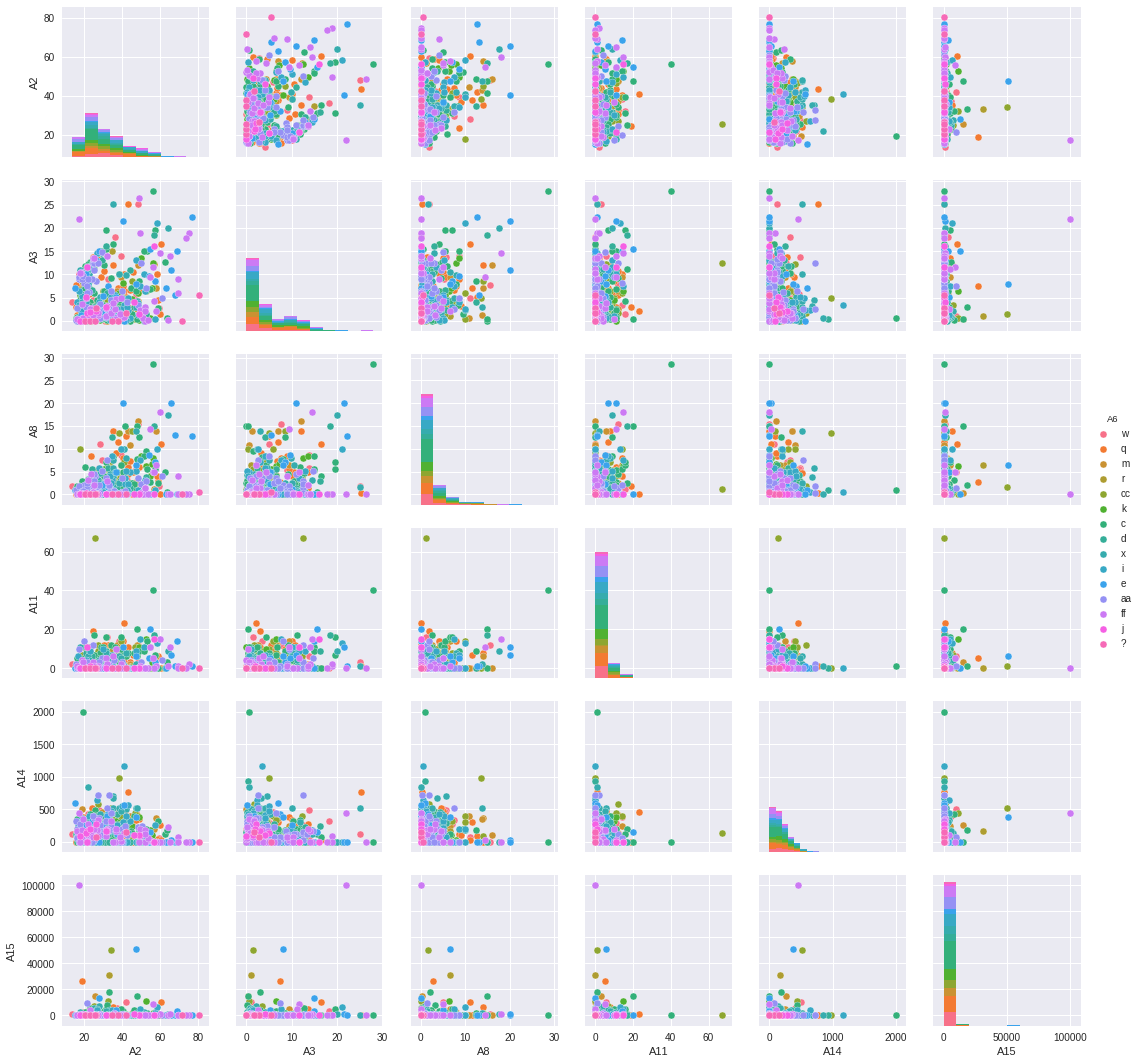

In [89]:
'''
    A1: b, a.
    A2: continuous.
    A3: continuous.
    A4: u, y, l, t.
    A5: g, p, gg.
    A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
    A7: v, h, bb, j, n, z, dd, ff, o.
    A8: continuous.
    A9: t, f.
    A10: t, f.
    A11: continuous.
    A12: t, f.
    A13: g, p, s.
    A14: continuous.
    A15: continuous.
    A16: +,- (class attribute) ''' 

sns.pairplot(df, hue='A6'); # A6 will make the most colorful hue vector
# but of course none of the colors are gonna tell me anything useful. 

In [0]:
alpha = 0.05
numeric = df.select_dtypes(include='float64')
categ = df.select_dtypes(include='object')

class Student2samp:
  from itertools import permutations
  
  def __init__(self, data, test, sampsize=29): # pass it either 'rel' or 'ind'
    self.dat = data
    self.t = test
    self.N = sampsize

  def test(self, A,B): 
    if self.t=='rel': return stats.ttest_rel(A,B)
    elif self.t=='ind': return stats.ttest_ind(A,B)
    else: return "ERROR"
  
  def list_of_pairoffs(self):
    feats_perms = [cross for cross in permutations(self.dat.columns, r=2)]
    return feats_perms
  
  def enumerate_tests(self):
    '''The sampling happens on the method call'''
    perm_pairs = self.list_of_pairoffs()
    #print(perm_pairs)
    tests_dict = {cross: self.test(self.dat[cross[0]].sample(self.N), self.dat[cross[1]].sample(self.N)) for cross in perm_pairs}
    outcomes = pd.DataFrame.from_dict(tests_dict, orient='columns')
    return outcomes.T.rename(columns={0:'stat', 1:'p-value'})
    
  def significant(self):
    '''determine which are significant
    
    assume that any NaN was from divide by zero in sampling
    '''
    sigs = self.enumerate_tests().dropna()
    #sigs[sigs['p-value'] < alpha]
    return sigs[sigs['p-value'] < alpha]
    
 

In [274]:
Student2samp(numeric, 'rel').significant()

Student2samp(numeric, 'ind').significant()



stat       p-value
A11 A14  -6.316221  4.628186e-08
    A3   -2.946900  4.671585e-03
A14 A11   8.204359  3.568625e-11
    A2    6.847272  6.186127e-09
A15 A11   3.377570  1.335938e-03
    A3    2.531352  1.419706e-02
    A8    2.716143  8.768497e-03
A2  A11  12.091888  3.020373e-17
    A3    9.769719  1.056328e-13
A3  A11   2.288415  2.590893e-02
    A15  -2.052389  4.481686e-02
    A8    2.762611  7.743187e-03
A8  A2  -16.765611  1.723511e-23
    A3   -2.609832  1.159863e-02

In [285]:
categ.T.value_counts()

AttributeError: ignored

## Part 3 - Analysis and Interpretation

Now that you've looked at the data, answer the following questions:

- Interpret and explain the two t-tests you ran - what do they tell you about the relationships between the continuous features you selected and the class labels?
- Interpret and explain the two Chi-squared tests you ran - what do they tell you about the relationships between the categorical features you selected and the class labels?
- What was the most challenging part of this sprint challenge?

Answer with text, but feel free to intersperse example code/results or refer to it from earlier.

*Your words here!*